### try to convert mocap to smplh using optimization -> failed

In [1]:
# !pip install git+https://github.com/nghorbani/human_body_prior

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
df = pd.read_csv("input/angry_12_000_worldpos.csv")
joints = set(df.columns) - {"Time"}
joints = {j[:-2] for j in joints}
joints

{'Head',
 'HeadEnd',
 'Hips',
 'LHipJoint',
 'LThumb',
 'LThumbEnd',
 'LeftArm',
 'LeftFingerBase',
 'LeftFoot',
 'LeftForeArm',
 'LeftHand',
 'LeftHandIndex1',
 'LeftHandIndex1End',
 'LeftLeg',
 'LeftShoulder',
 'LeftToeBase',
 'LeftToeBaseEnd',
 'LeftUpLeg',
 'LowerBack',
 'Neck',
 'Neck1',
 'RHipJoint',
 'RThumb',
 'RThumbEnd',
 'RightArm',
 'RightFingerBase',
 'RightFoot',
 'RightForeArm',
 'RightHand',
 'RightHandIndex1',
 'RightHandIndex1End',
 'RightLeg',
 'RightShoulder',
 'RightToeBase',
 'RightToeBaseEnd',
 'RightUpLeg',
 'Spine',
 'Spine1'}

In [4]:
action2motion_joints = [8, 1, 2, 3, 4, 5, 6, 7, 0, 9, 10, 11, 12, 13, 14, 21, 24, 38]  # [18,]

In [5]:
# aproximate noramlization
inputJoint = np.load("input/angry_12_000.npy")[20] / 25

In [6]:
import torch
from human_body_prior.body_model.body_model import BodyModel

# Setup
model_path = '../../models/smplh/models/neutral/SMPLH_NEUTRAL.npz'
device = 'cuda' if torch.cuda.is_available() else 'cpu'
bm = BodyModel(bm_fname=model_path, num_betas=16).to(device)

# Target joints: your 18x3 numpy array
target_joints = torch.tensor(inputJoint, dtype=torch.float32, device=device).unsqueeze(0)

# Initialize pose
pose_body = torch.rand((1, 63), requires_grad=True, device=device)
pose_hand = torch.rand((1, 90), requires_grad=True, device=device)
root_orient = torch.rand((1, 3), requires_grad=True, device=device)

betas = torch.rand((1, 16), requires_grad=True, device=device)
trans = torch.rand((1, 3), requires_grad=True, device=device)

optimizer = torch.optim.Adam([pose_body, root_orient, trans, betas, pose_hand], lr=0.01)
# optimizer = torch.optim.Adam([pose_body, root_orient, pose_hand], lr=0.01)


# Optimization loop
for i in range(1000):
    bm_out = bm(pose_body=pose_body, pose_hand=pose_hand, betas=betas, trans=trans, root_orient=root_orient)
    # bm_out = bm(pose_body=pose_body, pose_hand=pose_hand, root_orient=root_orient)

    pred_joints = bm_out.Jtr[0, action2motion_joints, :]  # Take only the first 18 joints


    # reg
    pose_reg_weight = 1e-4
    beta_reg_weight = 5e-4
    joint_loss = ((pred_joints - target_joints) ** 2).mean()

    # === Regularization terms ===
    pose_reg = (pose_body ** 2).mean() + (pose_hand ** 2).mean()
    beta_reg = (betas ** 2).mean()

    loss = joint_loss + pose_reg_weight * pose_reg + beta_reg_weight * beta_reg


    # loss = ((pred_joints - target_joints) ** 2).mean()
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()


    if i % 50 == 0:
        print(f"Step {i}: Loss = {loss.item()}")


Step 0: Loss = 0.30175527930259705
Step 50: Loss = 0.02203054539859295
Step 100: Loss = 0.009849565103650093
Step 150: Loss = 0.005847868509590626
Step 200: Loss = 0.004379078280180693
Step 250: Loss = 0.003603664692491293
Step 300: Loss = 0.0030888004694133997
Step 350: Loss = 0.00271380296908319
Step 400: Loss = 0.0024263120722025633
Step 450: Loss = 0.0022005813661962748
Step 500: Loss = 0.002021308522671461
Step 550: Loss = 0.0018778226803988218
Step 600: Loss = 0.0017621212173253298
Step 650: Loss = 0.0016681092092767358
Step 700: Loss = 0.0015911785885691643
Step 750: Loss = 0.0015278678620234132
Step 800: Loss = 0.0014755665324628353
Step 850: Loss = 0.0014322856441140175
Step 900: Loss = 0.0013964702375233173
Step 950: Loss = 0.0013668653555214405


In [7]:
index_to_joint = [
    'pelvis',           # 0
    'left_hip',         # 1
    'right_hip',        # 2
    'spine1',           #
    'left_knee',        #
    'right_knee',       #
    'spine2',           #
    'left_ankle',       #
    'right_ankle',      #
    'spine3',           #
    'left_foot',        #
    'right_foot',       #
    'neck',             #
    'left_collar',      #
    'right_collar',     #
    'head',             #
    'left_shoulder',    #
    'right_shoulder',   #
    'left_elbow',       #
    'right_elbow',      #
    'left_wrist',       #
    'right_wrist',      # 21
    'left_index1',      # 22
    'left_index2',      #
    'left_index3',      #
    'left_middle1',     #
    'left_middle2',     #
    'left_middle3',     #
    'left_pinky1',      #
    'left_pinky2',      #
    'left_pinky3',      #
    'left_ring1',       #
    'left_ring2',       #
    'left_ring3',       #
    'left_thumb1',      #
    'left_thumb2',      #
    'left_thumb3',      #
    'right_index1',     # 37
    'right_index2',     #
    'right_index3',     #
    'right_middle1',    #
    'right_middle2',    #
    'right_middle3',    #
    'right_pinky1',     #
    'right_pinky2',     #
    'right_pinky3',     #
    'right_ring1',      #
    'right_ring2',      #
    'right_ring3',      #
    'right_thumb1',     #
    'right_thumb2',     #
    'right_thumb3',     # 51
    'nose',             #
    'right_eye',        #
    'left_eye',         #
    'right_ear',        #
    'left_ear',         #
    'left_big_toe',     #
    'left_small_toe',   #
    'left_heel',        #
    'right_big_toe',    #
    'right_small_toe',  #
    'right_heel',       #
    'left_thumb',       #
    'left_index',       #
    'left_middle',      #
    'left_ring',        #
    'left_pinky',       #
    'right_thumb',      #
    'right_index',      #
    'right_middle',     #
    'right_ring',       #
    'right_pinky',      #
]

In [8]:

joints = [ 8, 1, 2, 3, 4, 5, 6, 7, 0, 9, 10, 11, 12, 13, 14, 21, 24, 38 ]

joints = [index_to_joint[j] for j in joints]
print(joints)
joints_to_index = {j:i for i, j in enumerate(joints)}
print(joints_to_index)

['right_ankle', 'left_hip', 'right_hip', 'spine1', 'left_knee', 'right_knee', 'spine2', 'left_ankle', 'pelvis', 'spine3', 'left_foot', 'right_foot', 'neck', 'left_collar', 'right_collar', 'right_wrist', 'left_index3', 'right_index2']
{'right_ankle': 0, 'left_hip': 1, 'right_hip': 2, 'spine1': 3, 'left_knee': 4, 'right_knee': 5, 'spine2': 6, 'left_ankle': 7, 'pelvis': 8, 'spine3': 9, 'left_foot': 10, 'right_foot': 11, 'neck': 12, 'left_collar': 13, 'right_collar': 14, 'right_wrist': 15, 'left_index3': 16, 'right_index2': 17}


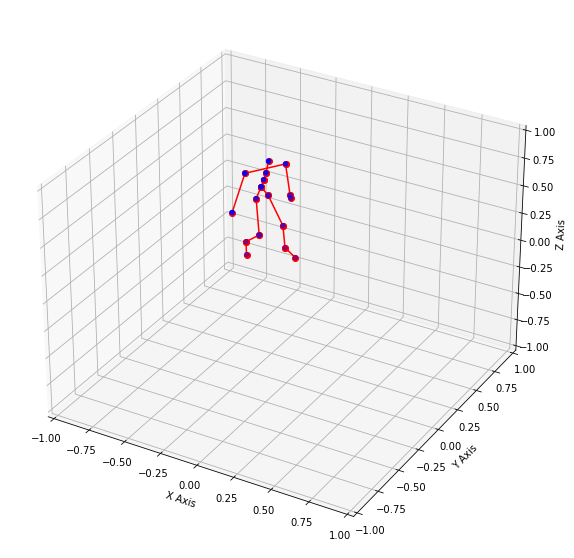

In [9]:
def plot(points):
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')

    ax.cla()

    ax.set_xlim(-1, 1)
    ax.set_ylim(-1, 1)
    ax.set_zlim(-1, 1)

    x = points[:, 0]
    y = points[:, 1]
    z = points[:, 2]
    ax.scatter(x, y, z, c='b', marker='o')  # Scatter plot for the points

    for v in [
        ('pelvis', 'left_hip'), ('pelvis', 'right_hip'),
        ('left_hip', 'left_knee'), ('right_hip', 'right_knee'),
        ('left_knee', 'left_ankle'), ('right_knee', 'right_ankle'),
        ('left_ankle', 'left_foot'), ('right_ankle', 'right_foot'),
        ('pelvis', 'spine1'),
        ('spine1', 'spine2'),
        ('spine2', 'spine3'),
        ('spine3', 'neck'),
        ('left_collar', 'right_collar'),
        ('right_collar', 'right_wrist'),
        ('right_wrist', 'right_index2'),
        ('left_collar', 'left_index3')
    ]:
        vec = [joints_to_index[j] for j in v]

        ax.plot(xs=x[vec], ys=y[vec], zs=z[vec], c='r', linestyle='-', marker='o')  # Line plot connecting the points


    # Set labels for the axes
    ax.set_xlabel('X Axis')
    ax.set_ylabel('Y Axis')
    ax.set_zlabel('Z Axis')

    # Set the title
    # ax.set_title(data["text_raw_labels"][data_index][frame_idx])

    # Show the plot
    plt.draw()# 

plot(inputJoint)

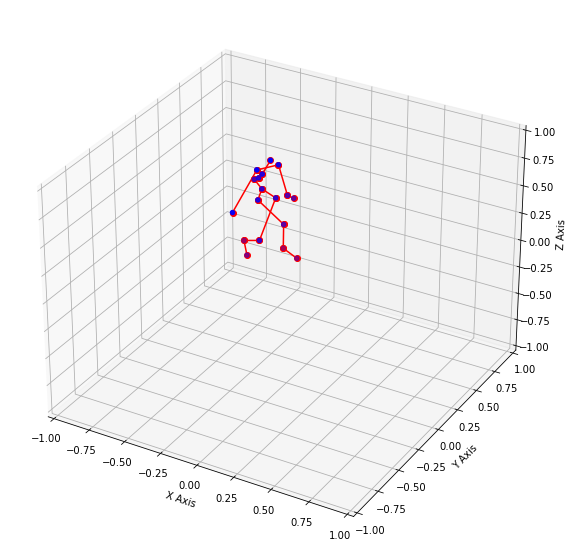

In [10]:
plot(bm_out.Jtr[0, action2motion_joints].cpu().detach().numpy())

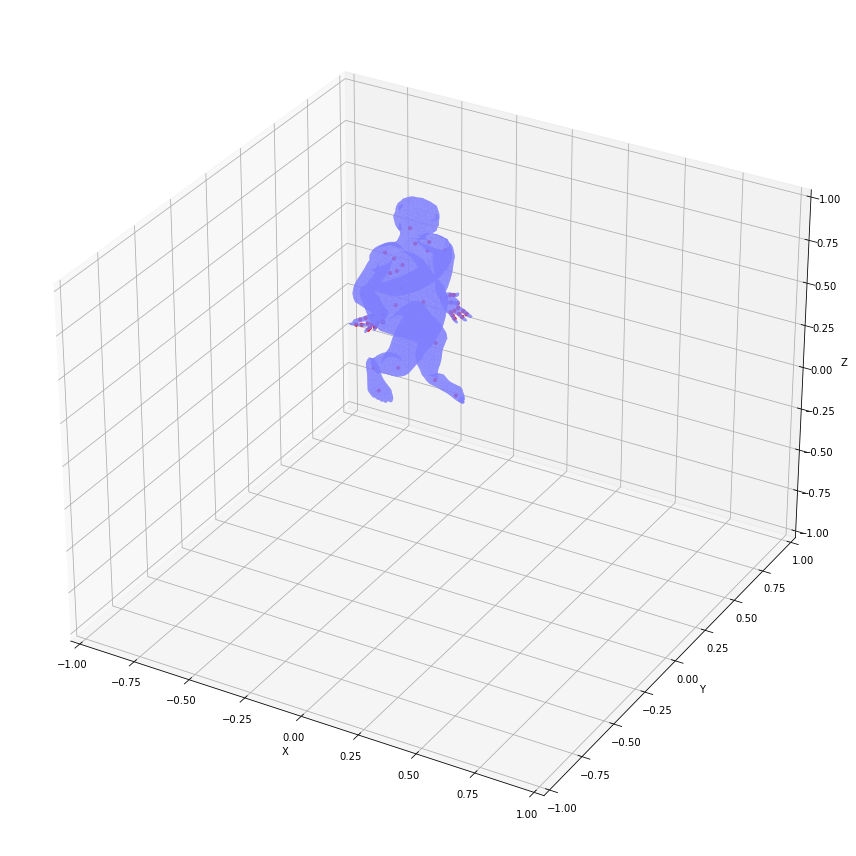

In [11]:

from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import matplotlib.pyplot as plt

# def plot_mesh_matplotlib(vertices, faces, title='SMPL-H Mesh'):
# Use it after SMPL-H output



# Run after SMPL-H forward pass
idx = 0
vertices = bm_out.v[idx].detach().cpu().numpy()
faces = bm_out.f.detach().cpu().numpy()


fig = plt.figure(figsize=(16, 12))
ax = fig.add_subplot(111, projection='3d')

mesh = Poly3DCollection(vertices[faces], alpha=0.7)
mesh.set_facecolor([0.5, 0.5, 1, 0.7])
ax.add_collection3d(mesh)

# Auto scale to the mesh size
x, y, z = vertices.T
# ax.set_xlim([x.min(), x.max()])
# ax.set_ylim([y.min(), y.max()])
# ax.set_zlim([z.min(), z.max()])
ax.set_xlim([-1, 1])
ax.set_ylim([-1, 1])
ax.set_zlim([-1, 1])
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
# ax.view_init(elev=20, azim=60)


x, y, z = bm_out.Jtr[idx].T.cpu().detach().numpy()

# plt.scatter(x, y, z)
ax.scatter(x, y, z, c='r', marker='o', alpha=1, s=10)  # Scatter plot for the points

plt.tight_layout()
plt.show()